In [135]:
from Data import *
import pandas as pd
import os
from tqdm import tqdm_notebook as tqdm
from gprofiler import GProfiler
import requests
from matplotlib import ticker
import matplotlib.pyplot as plt

# 1- Load Data

In [143]:
#Load Data
dataset = "CCLE"
cancer = "COAD"
network = "DW"

DataC=Data(cancer,dataset,network,mut_ppi_filter=False)
#Load mutations
mut_dic=DataC.get_mutation_data()
#Load drug targets (personalized reference sets)
drug_targets=DataC.load_gdsc_depmap_reference_sets(cancer)

---- Data ----
A) LOAD Data
   1) Mutation data loaded for  36  samples.  (19539, 36)
   3) Reference sets from  [GDSC U DepMap] data loaded


In [19]:
def load_method_results(model):
    drivers={}
    with open(str(model)+'') as ifile:
        for line in ifile.readlines():
            drivers[line.strip().split("\t")[0].replace(".","-")]=line.strip().split("\t")[1:]
    return drivers

# 2 -  Select Samples with at least K ranked Genes

In [20]:
#select samples with at least k ranked genes among all models under concideration
def select_samples(cancer,dataset,network,drug_targets):
    select_cells=[]
    for c in drug_targets:
        selected=True
        for method in os.listdir("results/{}/{}_{}/".format(dataset,cancer,network)):
            if '.txt' in method:
                method_drivers=load_method_results("results/{}/{}_{}/{}".format(dataset,cancer,network,method))
                if len(method_drivers[c])<20:
                    selected=False
        if selected:
            select_cells.append(c)
    return select_cells


In [144]:
selected_cells=select_samples(cancer,dataset,network,drug_targets)
print(len(selected_cells))

25


# 3 - gProfiler

In [145]:
#------Uploading a custom KEGG pathways from (Kanehisa et al., 2020) 
content = open('data/enrichment_analysis/kegg_pathways_v1.gmt').read()
#POST request with the file content in JSON
gProfiler_Custom_Data = requests.post('https://biit.cs.ut.ee/gprofiler/api/gost/custom',
             json = {
                     'gmt':content,
                     'name':'kegg_pathways_v1.gmt'
                    })
KEGG_custom = gProfiler_Custom_Data.json()['organism']
#KEGG analysis using gProfiler

### 3.1 KEGG gProfiler

In [146]:
def KEGG_enrichment(data,background):
    gp = GProfiler(return_dataframe=True)
    gProfiler_output=gp.profile(organism=KEGG_custom,
                                        query=data,domain_scope='custom',background=background,all_results=False)
    return gProfiler_output

### 3.2 Reactome gProfiler

In [147]:
#Reactome analysis using gProfiler
def Reactome_enrichment(data,background):
    gp = GProfiler(return_dataframe=True)
    gProfiler_output=gp.profile(organism="hsapiens",sources=["REAC"],
                                        query=data,domain_scope='custom',background=background,all_results=False)
    return gProfiler_output

### 3.3 Run gProfiler

In [55]:
#select samples with at least k ranked genes among all models under concideration
def methods_analysis(cancer,dataset,network,selected_cells,mut_dic):
    for method in tqdm(os.listdir("results/{}/{}_{}/".format(dataset,cancer,network))):
        if '.txt' in method:
            try:
                if not os.path.exists("results/{}/{}_{}/Enrichments/".format(dataset,cancer,network)):
                    os.mkdir("results/{}/{}_{}/Enrichments/".format(dataset,cancer,network))
                    os.mkdir("results/{}/{}_{}/Enrichments/KEGG/".format(dataset,cancer,network))
                    os.mkdir("results/{}/{}_{}/Enrichments/REAC/".format(dataset,cancer,network))
                if not os.path.exists("results/{}/{}_{}/Enrichments/KEGG/{}/".format(dataset,cancer,network,method.split(".txt"[0]))):
                    os.mkdir("results/{}/{}_{}/Enrichments/KEGG/{}/".format(dataset,cancer,network,method.split(".txt")[0]))
                    os.mkdir("results/{}/{}_{}/Enrichments/REAC/{}/".format(dataset,cancer,network,method.split(".txt")[0]))
            except:
                print("error: directory")
            method_drivers=load_method_results("results/{}/{}_{}/{}".format(dataset,cancer,network,method))
            for c in selected_cells:
                kegg_results=KEGG_enrichment(method_drivers[c][:20],mut_dic[c])
                reactome_results=Reactome_enrichment(method_drivers[c][:20],mut_dic[c])
                kegg_results.to_csv("results/{}/{}_{}/Enrichments/KEGG/{}/{}.csv".format(dataset,cancer,network,method.split(".txt")[0],c))
                reactome_results.to_csv("results/{}/{}_{}/Enrichments/REAC/{}/{}.csv".format(dataset,cancer,network,method.split(".txt")[0],c))
       
        
def reference_analysis(cancer,dataset,network,selected_cells,mut_dic,drug_targets):
    
    try:
        if not os.path.exists("results/{}/{}_{}/Enrichments/Ref_KEGG/".format(dataset,cancer,network)):
            os.mkdir("results/{}/{}_{}/Enrichments/Ref_KEGG/".format(dataset,cancer,network))
        if not os.path.exists("results/{}/{}_{}/Enrichments/Ref_REAC/".format(dataset,cancer,network)):
            os.mkdir("results/{}/{}_{}/Enrichments/Ref_REAC/".format(dataset,cancer,network))
    except:
        print("error: directory")
    for c in tqdm(selected_cells):
        kegg_results=KEGG_enrichment(drug_targets[c],mut_dic[c])
        reactome_results=Reactome_enrichment(drug_targets[c],mut_dic[c])
        kegg_results.to_csv("results/{}/{}_{}/Enrichments/Ref_KEGG/{}.csv".format(dataset,cancer,network,c))
        reactome_results.to_csv("results/{}/{}_{}/Enrichments/Ref_REAC/{}.csv".format(dataset,cancer,network,c))
        
    

In [ ]:
#run gProfiler
methods_analysis(cancer,dataset,network,selected_cells,mut_dic)
reference_analysis(cancer,dataset,network,selected_cells,mut_dic,drug_targets)

# EPO Scores

In [127]:
#KEGG Enrichment Analyais
def EPO(cancer,dataset,network,pathway_db):
    #kegg scores
    EPO_scores={}
    #load reference set KEGG pathways
    pathways_ref={}
    #for each cell line in the reference folder 
    for c in os.listdir("results/{}/{}_{}/Enrichments/Ref_{}/".format(dataset,cancer,network,pathway_db)):
        #load the enriched pathways for each reference set
        c_ref=pd.read_table("results/{}/{}_{}/Enrichments/Ref_{}/{}".format(dataset,cancer,network,pathway_db,c),sep=",")
        c_ref_pathways=set(c_ref["native"])
        if 'REAC:0000000' in c_ref_pathways:
            c_ref_pathways.remove('REAC:0000000')
        #if the set of the enriched pathways for the refence set c is not empty than store them
        if len(c_ref_pathways)>0:
            pathways_ref[c.split(".csv")[0]]=c_ref_pathways
    
    #for each method
    
    for method in os.listdir("results/{}/{}_{}/Enrichments/{}/".format(dataset,cancer,network,pathway_db)):
        #calclute EPO score
        score=0.0
        for c in pathways_ref:
            m_c_pathways=pd.read_table("results/{}/{}_{}/Enrichments/{}/{}/{}.csv".format(dataset,cancer,network,pathway_db,method,c),sep=",")
            m_c_pathways=set(m_c_pathways["native"])
            score+=(len(m_c_pathways.intersection(pathways_ref[c]))/len(pathways_ref[c]))
        EPO_scores[method]=score/len(pathways_ref)
    return EPO_scores




# EPO [KEGG]

In [128]:
KEGG_results=EPO(cancer,dataset,network,"KEGG")
KEGG_results

{'PersonaDrive': 0.7994015745157298,
 'DawnRank': 0.370111341344218,
 'SCS': 0.036781021370062464,
 'Prodigy': 0.061719451274245794}

# EPO [Reactome]

In [148]:
REAC_results=EPO(cancer,dataset,network,"REAC")
REAC_results

{'PersonaDrive': 0.36670539132542485,
 'DawnRank': 0.33443149315952697,
 'SCS': 0.0545388045082848,
 'Prodigy': 0.041363946077365016}

# Plot

In [141]:
def plot(KEGG_results,REAC_results):
    combined_scores={}
    for m in KEGG_results:
        combined_scores[m]={"KEGG":KEGG_results[m],"Reactome":REAC_results[m],}
    combined_scores=pd.DataFrame.from_dict(combined_scores)
    my_colors=["#ED553B","orange","#6d276a","#7F7F7F"]
    combined_scores.plot(kind='bar',color=my_colors,figsize=(6,8),fontsize=10)
    plt.legend(fontsize = 10)
        

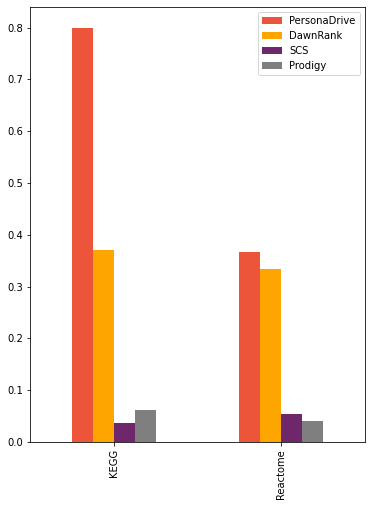

In [142]:
plot(KEGG_results,REAC_results)